# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
#pip install pyLDAvis==3.4.1 --user

In [2]:
#!pip install spacy

In [7]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict
spacy.cli.download("en")
nlp = spacy.load('en_core_web_sm')

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
# add any additional libaries you need here
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaMulticore, Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
import nltk
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Grigor\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [10]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [11]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [12]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [13]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

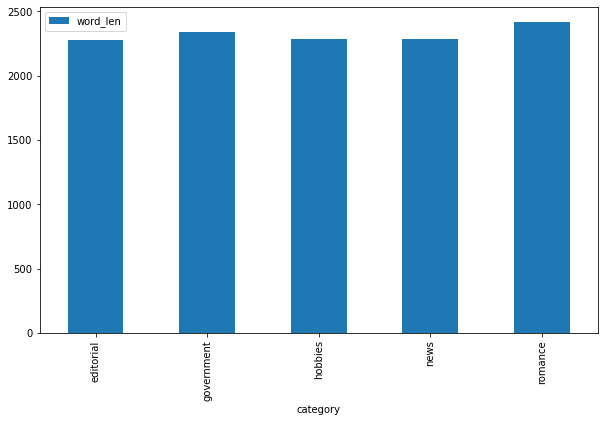

In [14]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [15]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

C:\Users\Grigor\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [16]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: From what I understand they are both a matrix.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [17]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [18]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [19]:
# Your code here
topics = defaultdict(list)

for index, row in enumerate(W_text_matrix) :
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[index]

    topics[topic[0]].append(category)

In [21]:
for topic, categories in topics.items() :
    print(f"For topic {topic} we have {len(categories)} documents")
    print(Counter(categories).most_common(5))

For topic 2 we have 65 documents
[('government', 26), ('hobbies', 26), ('news', 11), ('editorial', 2)]
For topic 0 we have 32 documents
[('editorial', 20), ('news', 8), ('government', 4)]
For topic 1 we have 41 documents
[('romance', 29), ('hobbies', 8), ('editorial', 4)]
For topic 4 we have 10 documents
[('news', 8), ('editorial', 1), ('hobbies', 1)]
For topic 3 we have 18 documents
[('news', 17), ('hobbies', 1)]


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: It looks like the NMF model found different results versus the original Brown

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [29]:
# Your code here
svd_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_model.components_

In [31]:
# call display_topics on your model
display_topics(svd_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.06)
  kennedy (0.82)
  laos (0.78)

Topic 03
  mrs (29.99)
  club (6.67)
  game (6.21)
  jr (5.71)
  dallas (5.47)

Topic 04
  game (4.46)
  league (3.20)
  baseball (3.18)
  ball (3.02)
  team (2.91)

Topic 05
  mrs (4.51)
  music (1.15)
  af (1.09)
  khrushchev (1.04)
  miss (0.98)

Topic 06
  faculty (184.24)
  college (178.80)
  student (139.55)
  shall (123.17)
  university (114.98)

Topic 07
  mrs (10.11)
  sales (5.92)
  marketing (4.33)
  billion (4.33)
  business (4.01)

Topic 08
  state (26.37)
  states (18.26)
  united (16.73)
  shall (15.81)
  mrs (15.67)

Topic 09
  shall (19.61)
  united (17.02)
  board (14.47)
  states (11.02)
  court (10.58)


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The lSA model was much more in line with the BRown results.

Q: What is your interpretation of the display topics output? 

A: It seems to me that the LSA model topic 00 and 01 are looking good.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
# Fit your LDA model here
count_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5,max_df=0.7)
count_vectors = count_vectorizer.fit_transform(df["text"])
count_vectors.shape

lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
W_lda_matrix = lda_model.fit_transform(count_vectors)
H_lda_matrix = lda_model.components_

C:\Users\Grigor\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [38]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  clay (0.54)
  game (0.47)
  place (0.45)
  cut (0.45)
  home (0.44)

Topic 01
  pool (0.77)
  use (0.71)
  national (0.70)
  area (0.57)
  good (0.56)

Topic 02
  million (0.60)
  military (0.57)
  sales (0.54)
  aircraft (0.54)
  equipment (0.50)

Topic 03
  feed (3.04)
  said (1.47)
  head (1.08)
  meeting (0.94)
  daily (0.91)

Topic 04
  said (1.83)
  sam (0.67)
  eyes (0.63)
  thought (0.63)
  little (0.58)

Topic 05
  mrs (1.05)
  said (0.88)
  old (0.67)
  mr (0.56)
  man (0.56)

Topic 06
  said (2.73)
  board (0.85)
  000 (0.66)
  court (0.56)
  county (0.55)

Topic 07
  state (1.08)
  medical (0.75)
  shelter (0.68)
  program (0.53)
  service (0.53)

Topic 08
  state (0.85)
  united (0.78)
  states (0.72)
  government (0.70)
  president (0.67)

Topic 09
  fiscal (1.00)
  property (0.86)
  island (0.69)
  tax (0.69)
  state (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: THE LDA model looks like it made a very different structure vs the other two.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: 

In [40]:
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [41]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 
